In [18]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor


# Models, Validation Type

This code loads the dataset, sets up the target variable and defines train-test year splits, while initializing several regression models, including Linear Regression, Lasso, Ridge, Random Forest, and XGBoost, along with their tuned versions for advanced modeling.

In [19]:

# Load the CSV file
df = pd.read_csv('/Users/avakrocheski-meyer/Downloads/TASK: 1119_start_to_finish/6_feature_generation/all_lagged.csv')

# Assuming the target variable is in logarithmic form
target_column = 'target_TOT_POPULATION'  # Replace with your actual target column

# Set train and test years
train_years = list(range(2010, 2017))  # 2010-2016
test_years = [2017, 2018]  # Final two years

# Define models
best_lasso_alpha = 1e-05
best_ridge_alpha = 0.001

models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=best_lasso_alpha, random_state=42),
    'Ridge Regression': Ridge(alpha=best_ridge_alpha, random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'XGBoostTuned': XGBRegressor(
        random_state=42,
        learning_rate=0.05,
        max_depth=5,
        n_estimators=250
    ),
    'RandomForestTuned': RandomForestRegressor(
        random_state=42,
        max_depth=10,
        min_samples_split=2,
        n_estimators=150
    )
}


This function checks the dataset for NaN or infinite values in the features (X) and target variable (y), printing warnings if such values are found or confirming that the data is clean.

In [20]:
def validate_data(X, y):
    if np.any(np.isnan(X)) or np.any(np.isnan(y)):
        print("NaN values found in the dataset!")
    if np.any(np.isinf(X)) or np.any(np.isinf(y)):
        print("Infinity values found in the dataset!")
    print("Data looks clean.")

This function trains a model on X_train and y_train, predicts on X_val, and calculates performance metrics (MSE, MAE, RMSE, R²) for both logarithmic and original target values.

In [21]:
# Function to perform cross-validation and return evaluation metrics
def cross_val_model(X_train, y_train, X_val, y_val, model):
    #validate_data(X_train, y_train)
    #validate_data(X_val, y_val)

    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    rmse = np.sqrt(mse)

    y_val_orig = np.exp(y_val)
    y_pred_orig = np.exp(y_pred)

    mse_orig = mean_squared_error(y_val_orig, y_pred_orig)
    rmse_orig = np.sqrt(mse_orig)
    r2_orig = r2_score(y_val_orig, y_pred_orig)

    return mse, mae, rmse, r2, mse_orig, r2_orig, rmse_orig


This function conducts expanding window cross-validation, training on incrementally larger year ranges and evaluating model performance on the next year using metrics in both log-transformed and original scales.

In [22]:
# Function to perform expanding window cross-validation
def expanding_window_cv(df, start_year, end_year, target_column, model):
    results = []
    years = sorted(df['Year'].unique())
    years = [y for y in years if start_year <= y <= end_year]
    for i in range(3, len(years)):
        train_years = years[:i]
        val_year = years[i]
        train_data = df[df['Year'].isin(train_years)]
        val_data = df[df['Year'] == val_year]

        # Separate features and target
        X_train = train_data.drop(columns=[target_column, 'GEO_ID', 'Year'])
        y_train = train_data[target_column]
        X_val = val_data.drop(columns=[target_column, 'GEO_ID', 'Year'])
        y_val = val_data[target_column]

        # validate_data(X_train, y_train)
        # validate_data(X_val, y_val)


        # Train and evaluate model
        mse, mae, rmse, r2, mse_orig, r2_orig, rmse_orig = cross_val_model(X_train, y_train, X_val, y_val, model)
        results.append({'Year': val_year, 'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MSE Original Scale': mse_orig, 'R2 Original Scale': r2_orig, 'RMSE Original Scale': rmse_orig})
    
    return pd.DataFrame(results)


This function performs cross-validation by training a model on X_train and y_train, predicting on X_val, and calculating performance metrics in both log-transformed and original scales, including MSE, RMSE, and R².

In [23]:

# Function to perform fixed window cross-validation
def fixed_window_cv(df, start_year, end_year, target_column, model, window_size):
    results = []
    years = sorted(df['Year'].unique())
    years = [y for y in years if start_year <= y <= end_year]
    for i in range(window_size, len(years)):
        train_years = years[i-window_size:i]
        val_year = years[i]
        train_data = df[df['Year'].isin(train_years)]
        val_data = df[df['Year'] == val_year]

        # Separate features and target
        X_train = train_data.drop(columns=[target_column, 'GEO_ID', 'Year'])
        y_train = train_data[target_column]
        X_val = val_data.drop(columns=[target_column, 'GEO_ID', 'Year'])
        y_val = val_data[target_column]

        #validate_data(X_train, y_train)
        #validate_data(X_val, y_val)


        # Train and evaluate model
        mse, mae, rmse, r2, mse_orig, r2_orig, rmse_orig = cross_val_model(X_train, y_train, X_val, y_val, model)
        results.append({'Year': val_year, 'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MSE Original Scale': mse_orig, 'R2 Original Scale': r2_orig, 'RMSE Original Scale': rmse_orig})
    
    return pd.DataFrame(results)


This function evaluates a trained model on a test set by training on specified train_years, predicting on test_years, and calculating metrics on both log-transformed and original scales.

In [24]:

# Function to evaluate model on the test set
def evaluate_on_test_set(df, train_years, test_years, target_column, model):
    train_data = df[df['Year'].isin(train_years)]
    test_data = df[df['Year'].isin(test_years)]
    
    # Separate features and target
    X_train = train_data.drop(columns=[target_column, 'GEO_ID', 'Year'])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column, 'GEO_ID', 'Year'])
    y_test = test_data[target_column]

    # Train and evaluate model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Convert back from log scale
    # y_pred_exp = np.exp(y_pred)
    # y_test_exp = np.exp(y_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    y_val_orig = np.exp(y_test)
    y_pred_orig = np.exp(y_pred)

    mse_orig = mean_squared_error(y_val_orig, y_pred_orig)
    r2_orig = r2_score(y_val_orig, y_pred_orig)
    rmse_orig = np.sqrt(mse_orig)
    
    return {'Year': '2017-2018', 'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MSE Original Scale': mse_orig, 'R2 Original Scale': r2_orig, 'RMSE Original Scale': rmse_orig}


# Training, cross-validation

In [31]:

# Perform cross-validation for each model
results = []

for model_name, model in models.items():
    print(f"Processing {model_name}...")
    
    # Expanding Window CV
    expanding_results = expanding_window_cv(df, 2010, 2016, target_column, model)
    expanding_results['Model'] = model_name
    expanding_results['Validation Type'] = 'Expanding Window'
    results.append(expanding_results)
    
    # Fixed Window CV
    fixed_results = fixed_window_cv(df, 2010, 2016, target_column, model, window_size=3)
    fixed_results['Model'] = model_name
    fixed_results['Validation Type'] = 'Fixed Window'
    results.append(fixed_results)
    
    # Evaluation on Test Set
    test_eval = evaluate_on_test_set(df, train_years, test_years, target_column, model)
    test_eval['Model'] = model_name
    test_eval['Validation Type'] = 'Test Set'
    results.append(pd.DataFrame([test_eval]))

# Combine results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

# Format and display the results
pd.set_option('display.float_format', '{:.7f}'.format)
print("Evaluation Metrics for All Models:")
print(results_df[['Model', 'Validation Type', 'Year', 'MSE', 'MAE', 'RMSE', 'R2', 'MSE Original Scale', 'R2 Original Scale', 'RMSE Original Scale']])

# Optionally, pivot the table for better readability
pivot_df = results_df.pivot_table(index=['Model', 'Validation Type'], values=['MSE', 'MAE', 'RMSE', 'R2', 'MSE Original Scale', 'R2 Original Scale', 'RMSE Original Scale'], aggfunc='mean')
print("\nAverage Metrics by Model and Validation Type:")
print(pivot_df)

# Reset display format
pd.reset_option('display.float_format')


Processing Linear Regression...
Processing Lasso Regression...
Processing Ridge Regression...
Processing Random Forest...
Processing XGBoost...
Processing XGBoostTuned...
Processing RandomForestTuned...
Evaluation Metrics for All Models:
                Model   Validation Type       Year       MSE       MAE  \
0   Linear Regression  Expanding Window       2013 0.0001910 0.0107586   
1   Linear Regression  Expanding Window       2014 0.0000651 0.0057426   
2   Linear Regression  Expanding Window       2015 0.0000869 0.0075836   
3   Linear Regression  Expanding Window       2016 0.0000944 0.0064531   
4   Linear Regression      Fixed Window       2013 0.0001910 0.0107586   
..                ...               ...        ...       ...       ...   
58  RandomForestTuned      Fixed Window       2013 0.0003409 0.0120451   
59  RandomForestTuned      Fixed Window       2014 0.0003589 0.0121646   
60  RandomForestTuned      Fixed Window       2015 0.0003865 0.0131385   
61  RandomForestTuned 

Feature importance codes

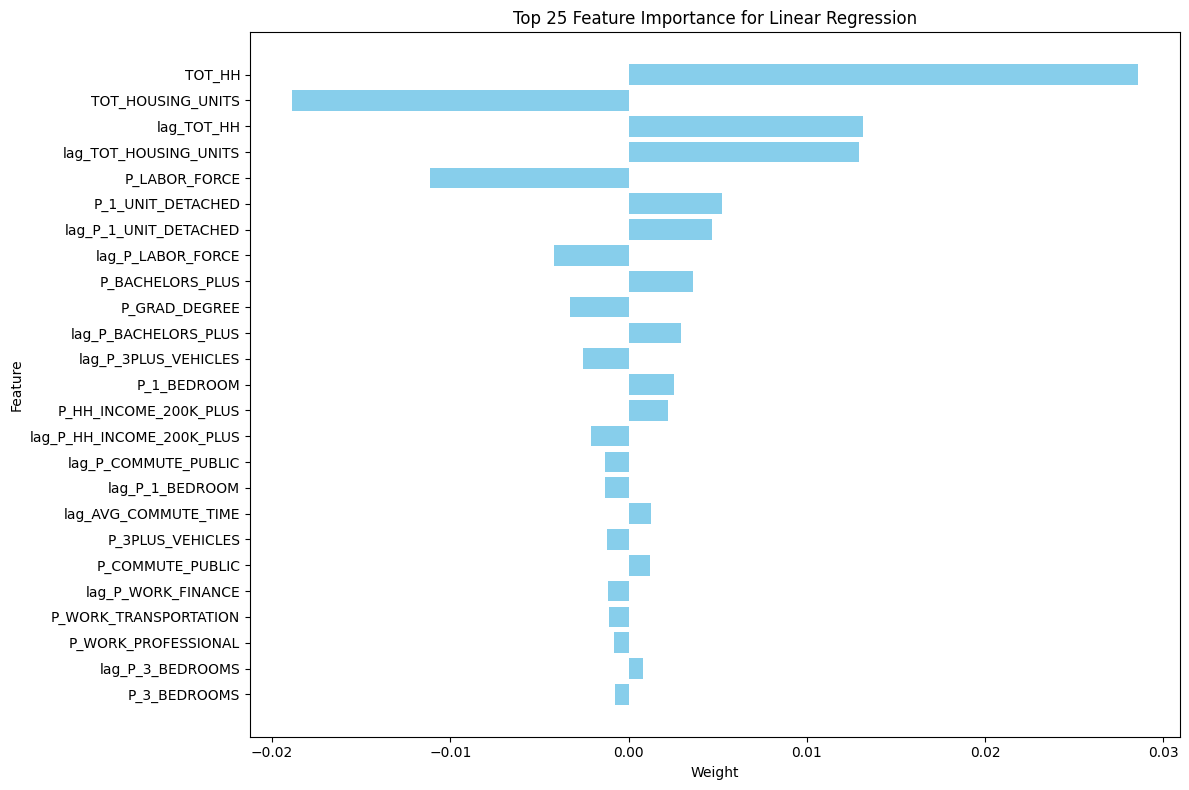

Top 25 Feature Importance:
                        Feature    Weight  Absolute Weight
15                      TOT_HH  0.028565         0.028565
6            TOT_HOUSING_UNITS -0.018861         0.018861
126                 lag_TOT_HH  0.013168         0.013168
130      lag_TOT_HOUSING_UNITS  0.012927         0.012927
14               P_LABOR_FORCE -0.011109         0.011109
22           P_1_UNIT_DETACHED  0.005217         0.005217
138      lag_P_1_UNIT_DETACHED  0.004670         0.004670
144          lag_P_LABOR_FORCE -0.004155         0.004155
9             P_BACHELORS_PLUS  0.003600         0.003600
23               P_GRAD_DEGREE -0.003261         0.003261
143       lag_P_BACHELORS_PLUS  0.002936         0.002936
145       lag_P_3PLUS_VEHICLES -0.002569         0.002569
13                 P_1_BEDROOM  0.002546         0.002546
16       P_HH_INCOME_200K_PLUS  0.002208         0.002208
133  lag_P_HH_INCOME_200K_PLUS -0.002092         0.002092
139       lag_P_COMMUTE_PUBLIC -0.001317    

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Load the CSV file
df = pd.read_csv('/Users/avakrocheski-meyer/Downloads/TASK: 1119_start_to_finish/6_feature_generation/all_lagged.csv')

# Assuming the target variable is in logarithmic form
target_column = 'target_TOT_POPULATION'  # Replace with your actual target column

# Set train and test years
train_years = list(range(2010, 2017))  # 2010-2016
test_years = [2017, 2018]  # Final two years

# Define the Linear Regression model
lr_model = LinearRegression()

# Train the Linear Regression model
train_data = df[df['Year'].isin(train_years)]
test_data = df[df['Year'].isin(test_years)]

X_train = train_data.drop(columns=[target_column, 'GEO_ID', 'Year'])
y_train = train_data[target_column]
X_test = test_data.drop(columns=[target_column, 'GEO_ID', 'Year'])
y_test = test_data[target_column]

lr_model.fit(X_train, y_train)

# Extract feature importance (weights) from Linear Regression
feature_names = X_train.columns
feature_weights = lr_model.coef_

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': feature_weights
})

# Remove unwanted features
exclude_features = [
    'TOT_POPULATION', 'TOT_POPULATION_3YR_ROLLING', 'lag_TOT_CIV_POP', 
    'TOT_CIV_POP', 'CIV_POP_16', 'lag_CIV_POP_16', 'lag_TOT_POPULATION', 
    'CIV_POP_18+', 'lag_CIV_POP_18+'
]
feature_importance_df = feature_importance_df[~feature_importance_df['Feature'].str.startswith('GEO_ID')]
feature_importance_df = feature_importance_df[~feature_importance_df['Feature'].isin(exclude_features)]

# Sort features by absolute weight for better visualization
feature_importance_df['Absolute Weight'] = feature_importance_df['Weight'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute Weight', ascending=False)

# Extract top 25 features
top_25_features = feature_importance_df.head(25)

# Save feature importance scores to a CSV file
top_25_features.to_csv('linear_regression_top_25_feature_importance.csv', index=False)

# Plot the top 25 feature importance
plt.figure(figsize=(12, 8))
plt.barh(top_25_features['Feature'], top_25_features['Weight'], color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Top 25 Feature Importance for Linear Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print top 25 feature importance for reference
print("Top 25 Feature Importance:\n", top_25_features)

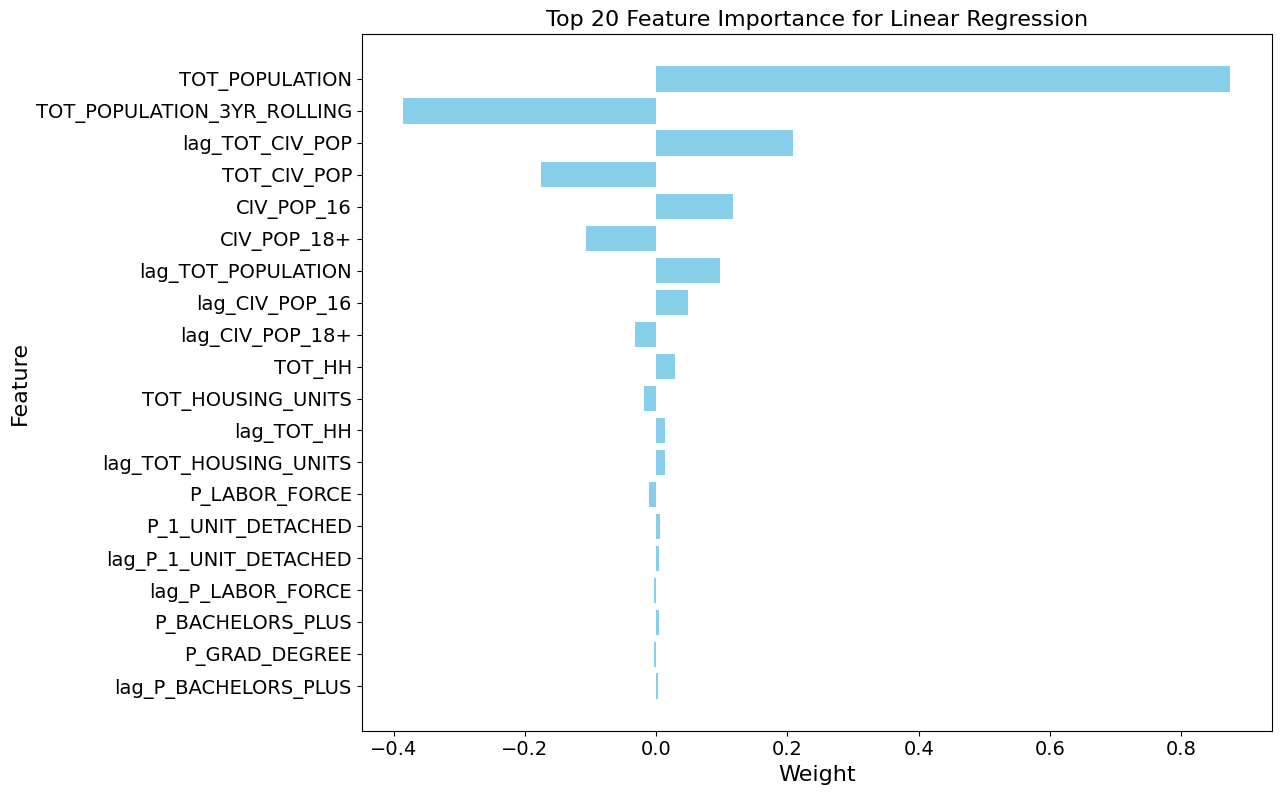

Top 20 Feature Importance:
                         Feature    Weight  Absolute Weight
0                TOT_POPULATION  0.874898         0.874898
125  TOT_POPULATION_3YR_ROLLING -0.386005         0.386005
128             lag_TOT_CIV_POP  0.208931         0.208931
12                  TOT_CIV_POP -0.175464         0.175464
2                    CIV_POP_16  0.116553         0.116553
5                   CIV_POP_18+ -0.107685         0.107685
131          lag_TOT_POPULATION  0.097431         0.097431
129              lag_CIV_POP_16  0.048909         0.048909
127             lag_CIV_POP_18+ -0.033111         0.033111
15                       TOT_HH  0.028565         0.028565
6             TOT_HOUSING_UNITS -0.018861         0.018861
126                  lag_TOT_HH  0.013168         0.013168
130       lag_TOT_HOUSING_UNITS  0.012927         0.012927
14                P_LABOR_FORCE -0.011109         0.011109
22            P_1_UNIT_DETACHED  0.005217         0.005217
138       lag_P_1_UNIT_DETAC

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Load the CSV file
df = pd.read_csv('/Users/avakrocheski-meyer/Downloads/TASK: 1119_start_to_finish/6_feature_generation/all_lagged.csv')

# Assuming the target variable is in logarithmic form
target_column = 'target_TOT_POPULATION'  # Replace with your actual target column

# Set train and test years
train_years = list(range(2010, 2017))  # 2010-2016
test_years = [2017, 2018]  # Final two years

# Define the Linear Regression model
lr_model = LinearRegression()

# Train the Linear Regression model
train_data = df[df['Year'].isin(train_years)]
test_data = df[df['Year'].isin(test_years)]

X_train = train_data.drop(columns=[target_column, 'GEO_ID', 'Year'])
y_train = train_data[target_column]
X_test = test_data.drop(columns=[target_column, 'GEO_ID', 'Year'])
y_test = test_data[target_column]

lr_model.fit(X_train, y_train)

# Extract feature importance (weights) from Linear Regression
feature_names = X_train.columns
feature_weights = lr_model.coef_

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': feature_weights
})

# Remove unwanted features
feature_importance_df = feature_importance_df[~feature_importance_df['Feature'].str.startswith('GEO_ID')]

# Sort features by absolute weight for better visualization
feature_importance_df['Absolute Weight'] = feature_importance_df['Weight'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute Weight', ascending=False)

# Extract top 25 features
top_25_features = feature_importance_df.head(20)

# Save feature importance scores to a CSV file
top_25_features.to_csv('linear_regression_top_25_feature_importance.csv', index=False)

# Plot the top 25 feature importance
plt.figure(figsize=(12, 8))
plt.barh(top_25_features['Feature'], top_25_features['Weight'], color='skyblue')
plt.xlabel('Weight', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Top 20 Feature Importance for Linear Regression', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Print top 25 feature importance for reference
print("Top 20 Feature Importance:\n", top_25_features)

This code trains and evaluates a single-feature linear regression model using TOT_POPULATION as the predictor for target_TOT_POPULATION, employing expanding window and fixed window cross-validation, as well as a final evaluation on the test set.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Make sure you have these functions defined or imported from your code:
# expanding_window_cv(df, start_year, end_year, target_column, model)
# fixed_window_cv(df, start_year, end_year, target_column, model, window_size=3)
# evaluate_on_test_set(df, train_years, test_years, target_column, model)

target_column = 'target_TOT_POPULATION'
start_year = 2010
end_year = 2018

# Create a separate DataFrame with only the necessary columns
df_single_feature = df[['Year', 'GEO_ID', target_column, 'TOT_POPULATION']].copy()

# Define the LinearRegression model
model_name = "Linear Regression (Single Feature)"
model = LinearRegression()

results = []

print(f"Processing {model_name}...")

# Expanding Window CV
expanding_results = expanding_window_cv(df_single_feature, start_year, end_year, target_column, model)
expanding_results['Model'] = model_name
expanding_results['Validation Type'] = 'Expanding Window'
results.append(expanding_results)

# Fixed Window CV
fixed_results = fixed_window_cv(df_single_feature, start_year, end_year, target_column, model, window_size=3)
fixed_results['Model'] = model_name
fixed_results['Validation Type'] = 'Fixed Window'
results.append(fixed_results)

# Define train_years and test_years based on your scenario
train_years = list(range(2010, 2017))  # 2010-2016
test_years = [2017, 2018]  # Final two years

# Evaluation on Test Set
test_eval = evaluate_on_test_set(df_single_feature, train_years, test_years, target_column, model)
test_eval['Model'] = model_name
test_eval['Validation Type'] = 'Test Set'
results.append(pd.DataFrame([test_eval]))

# Combine results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

pd.set_option('display.float_format', '{:.7f}'.format)
print("Evaluation Metrics for the Single-Feature Linear Regression:")
print(results_df[['Model', 'Validation Type', 'Year', 'MSE', 'MAE', 'RMSE', 'R2', 'MSE Original Scale', 'R2 Original Scale', 'RMSE Original Scale']])

# Optionally pivot the table for better readability
pivot_df = results_df.pivot_table(index=['Model', 'Validation Type'], 
                                  values=['MSE', 'MAE', 'RMSE', 'R2', 'MSE Original Scale', 'R2 Original Scale', 'RMSE Original Scale'], 
                                  aggfunc='mean')
print("\nAverage Metrics by Model and Validation Type:")
print(pivot_df)

# Reset display format
pd.reset_option('display.float_format')


Processing Linear Regression (Single Feature)...
Evaluation Metrics for the Single-Feature Linear Regression:
                                 Model   Validation Type       Year     MSE  \
0   Linear Regression (Single Feature)  Expanding Window       2013 0.00009   
1   Linear Regression (Single Feature)  Expanding Window       2014 0.00008   
2   Linear Regression (Single Feature)  Expanding Window       2015 0.00011   
3   Linear Regression (Single Feature)  Expanding Window       2016 0.00011   
4   Linear Regression (Single Feature)  Expanding Window       2017 0.00016   
5   Linear Regression (Single Feature)  Expanding Window       2018 0.00012   
6   Linear Regression (Single Feature)      Fixed Window       2013 0.00009   
7   Linear Regression (Single Feature)      Fixed Window       2014 0.00008   
8   Linear Regression (Single Feature)      Fixed Window       2015 0.00011   
9   Linear Regression (Single Feature)      Fixed Window       2016 0.00011   
10  Linear Regression

This code trains five different regression models (Linear Regression, Lasso, Ridge, Random Forest, XGBoost) on the training set (2010–2016), evaluates them on the test set (2017–2018), generates predictions for both sets, and visualizes the actual vs. predicted total population trends for selected cities with detailed time-series plots.

Training models on the full training set...


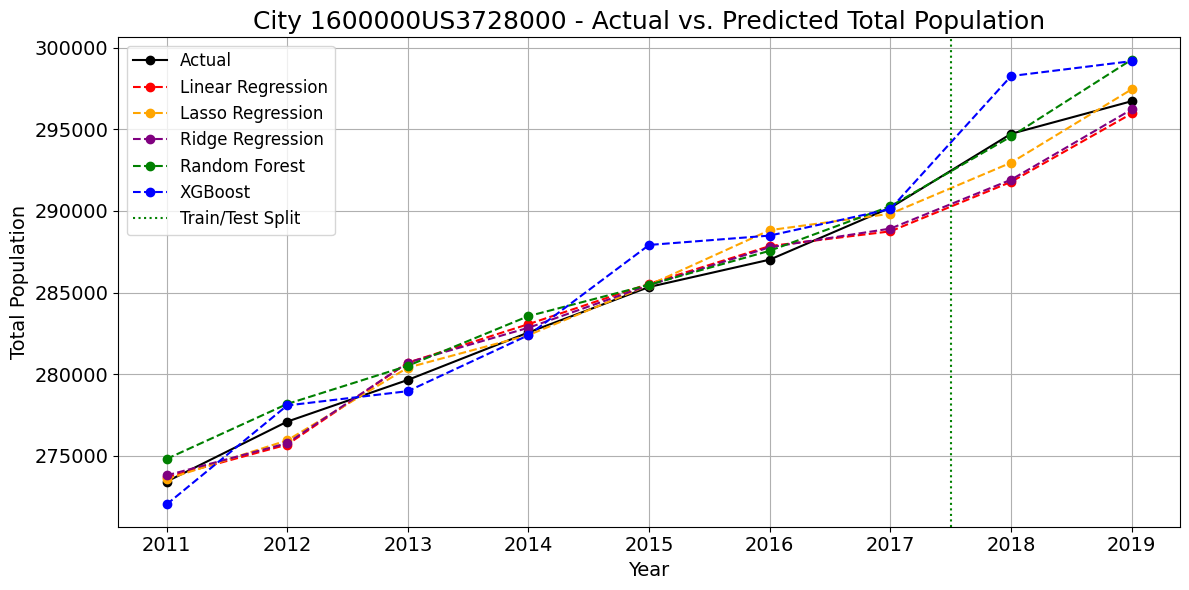

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define and initialize the models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(
        random_state=42,
        max_depth=10,
        min_samples_split=2,
        n_estimators=150
    )
xgb_model = XGBRegressor(
        random_state=42,
        learning_rate=0.05,
        max_depth=5,
        n_estimators=250
    )

lasso_model = Lasso(alpha=1e-05, random_state=42)  # Adjust alpha as needed
ridge_model = Ridge(alpha=0.001, random_state=42)  # Adjust alpha as needed

# Split the data into train and test sets based on the Year column
train_df = df[df['Year'].between(2010, 2016)].copy()
test_df = df[df['Year'].between(2017, 2018)].copy()  # Adjust the years according to your test set

# Separate features and target variable for training and testing
# Retain 'GEO_ID' and 'Year' in train_df and test_df for reference
X_train = train_df.drop(columns=['target_TOT_POPULATION'])  # Features for training
y_train = train_df['target_TOT_POPULATION']  # Target for training

X_test = test_df.drop(columns=['target_TOT_POPULATION'])  # Features for testing
y_test = test_df['target_TOT_POPULATION']  # Target for testing

# Train the models on the full training set
X_train_features = X_train.drop(columns=['GEO_ID', 'Year'])
X_test_features = X_test.drop(columns=['GEO_ID', 'Year'])

# Train each model
print("Training models on the full training set...")
lr_model.fit(X_train_features, y_train)
rf_model.fit(X_train_features, y_train)
xgb_model.fit(X_train_features, y_train)
lasso_model.fit(X_train_features, y_train)
ridge_model.fit(X_train_features, y_train)

# Generate predictions
y_pred_lr_train = lr_model.predict(X_train_features)
y_pred_rf_train = rf_model.predict(X_train_features)
y_pred_xgb_train = xgb_model.predict(X_train_features)
y_pred_lasso_train = lasso_model.predict(X_train_features)
y_pred_ridge_train = ridge_model.predict(X_train_features)

y_pred_lr_test = lr_model.predict(X_test_features)
y_pred_rf_test = rf_model.predict(X_test_features)
y_pred_xgb_test = xgb_model.predict(X_test_features)
y_pred_lasso_test = lasso_model.predict(X_test_features)
y_pred_ridge_test = ridge_model.predict(X_test_features)


# Split the data into train and test sets based on the Year column
train_df = df[df['Year'].between(2010, 2016)].copy()
test_df = df[df['Year'].between(2017, 2018)].copy()  # Adjust the years according to your test set

# Separate features and target variable for training and testing
# Retain 'GEO_ID' and 'Year' in train_df and test_df, but drop only 'target_TOT_POPULATION' for X_train and X_test
X_train = train_df.drop(columns=['target_TOT_POPULATION'])
y_train = train_df['target_TOT_POPULATION']

X_test = test_df.drop(columns=['target_TOT_POPULATION'])
y_test = test_df['target_TOT_POPULATION']

# Remove 'GEO_ID' and 'Year' from the feature sets
X_train_features = X_train.drop(columns=['GEO_ID', 'Year'])
X_test_features = X_test.drop(columns=['GEO_ID', 'Year'])

# Generate predictions on the entire dataset (both train and test) using the trained models

# Generate predictions on the training set
y_pred_lr_train = lr_model.predict(X_train_features)
y_pred_rf_train = rf_model.predict(X_train_features)
y_pred_xgb_train = xgb_model.predict(X_train_features)
y_pred_lasso_train = lasso_model.predict(X_train_features)
y_pred_ridge_train = ridge_model.predict(X_train_features)

# Generate predictions on the test set
y_pred_lr_test = lr_model.predict(X_test_features)
y_pred_rf_test = rf_model.predict(X_test_features)
y_pred_xgb_test = xgb_model.predict(X_test_features)
y_pred_lasso_test = lasso_model.predict(X_test_features)
y_pred_ridge_test = ridge_model.predict(X_test_features)

# Combine actual and predicted values for visualization

# For the training set
train_df['Actual'] = y_train.values
train_df['Pred_LR'] = y_pred_lr_train
train_df['Pred_RF'] = y_pred_rf_train
train_df['Pred_XGB'] = y_pred_xgb_train
train_df['Pred_Lasso'] = y_pred_lasso_train
train_df['Pred_Ridge'] = y_pred_ridge_train

# For the test set
test_df['Actual'] = y_test.values
test_df['Pred_LR'] = y_pred_lr_test
test_df['Pred_RF'] = y_pred_rf_test
test_df['Pred_XGB'] = y_pred_xgb_test
test_df['Pred_Lasso'] = y_pred_lasso_test
test_df['Pred_Ridge'] = y_pred_ridge_test

# Concatenate the training and test data for plotting
full_df = pd.concat([train_df, test_df])

# If your target variable was log-transformed, convert back to the original scale
# Exponentiate the 'Actual' and predicted columns
columns_to_transform = ['Actual', 'Pred_LR', 'Pred_RF', 'Pred_XGB', 'Pred_Lasso', 'Pred_Ridge']
for col in columns_to_transform:
    full_df[col] = np.exp(full_df[col])

# Select cities for plotting
# You can select specific cities or choose random ones
# For example, select 10 random cities
random_cities = np.random.choice(full_df['GEO_ID'].unique(), 1, replace=False)

# Plot time series for each selected city
for city in random_cities:
    city_data = full_df[full_df['GEO_ID'] == city].sort_values(by='Year')
    
    plt.figure(figsize=(12, 6))
    plt.plot(city_data['Year'] +1, city_data['Actual'], color='black', label='Actual', marker='o')
    plt.plot(city_data['Year'] +1, city_data['Pred_LR'], color='red', linestyle='--', marker='o', label='Linear Regression')
    plt.plot(city_data['Year'] +1, city_data['Pred_Lasso'], color='orange', linestyle='--', marker='o', label='Lasso Regression')
    plt.plot(city_data['Year'] +1, city_data['Pred_Ridge'], color='purple', linestyle='--', marker='o', label='Ridge Regression')
    plt.plot(city_data['Year'] +1, city_data['Pred_RF'], color='green', linestyle='--', marker='o', label='Random Forest')
    plt.plot(city_data['Year'] +1, city_data['Pred_XGB'], color='blue', linestyle='--', marker='o', label='XGBoost')
    
# Add a vertical line at the end of 2016 to separate training and test sets
    plt.axvline(x=2017.5, color='green', linestyle=':', linewidth=1.5, label='Train/Test Split')

    plt.title(f'City {city} - Actual vs. Predicted Total Population', fontsize=18)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Total Population', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize = 12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


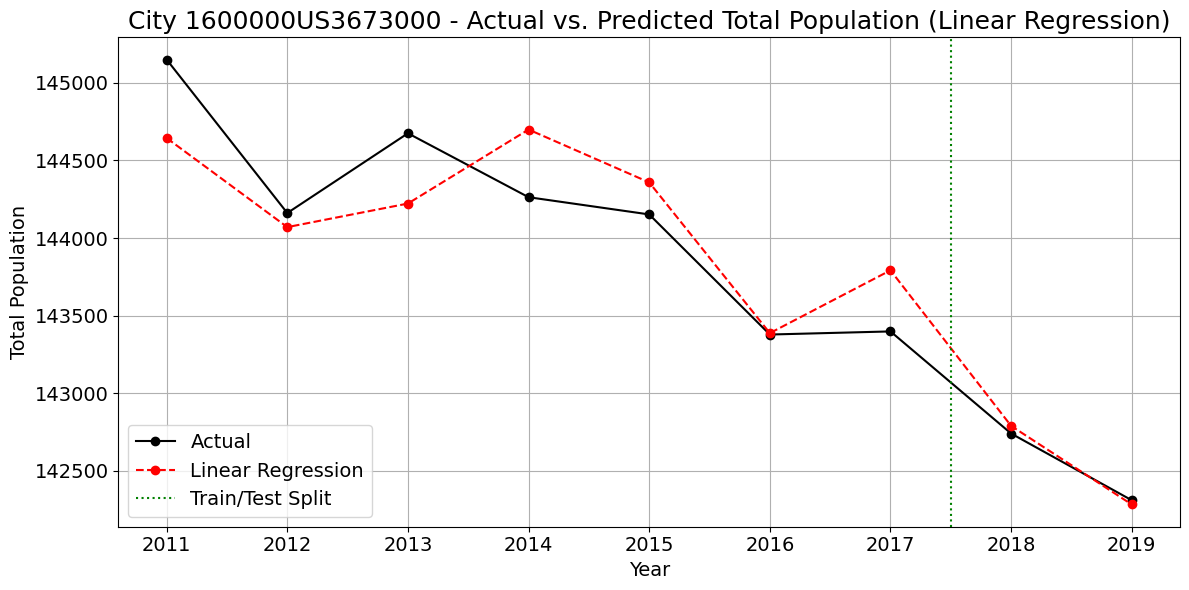

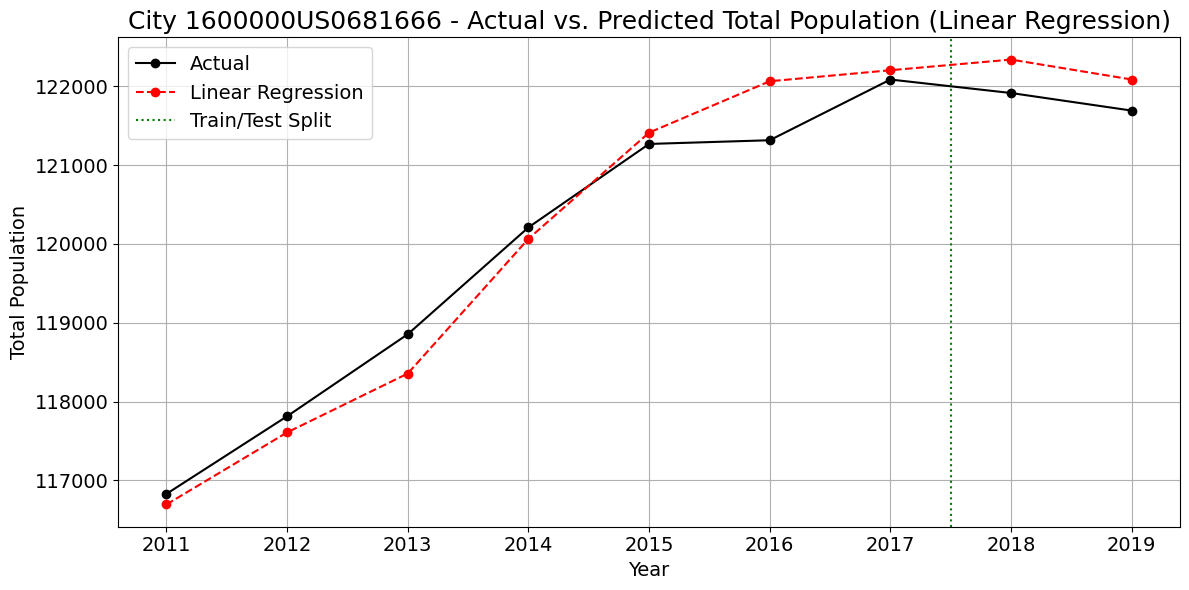

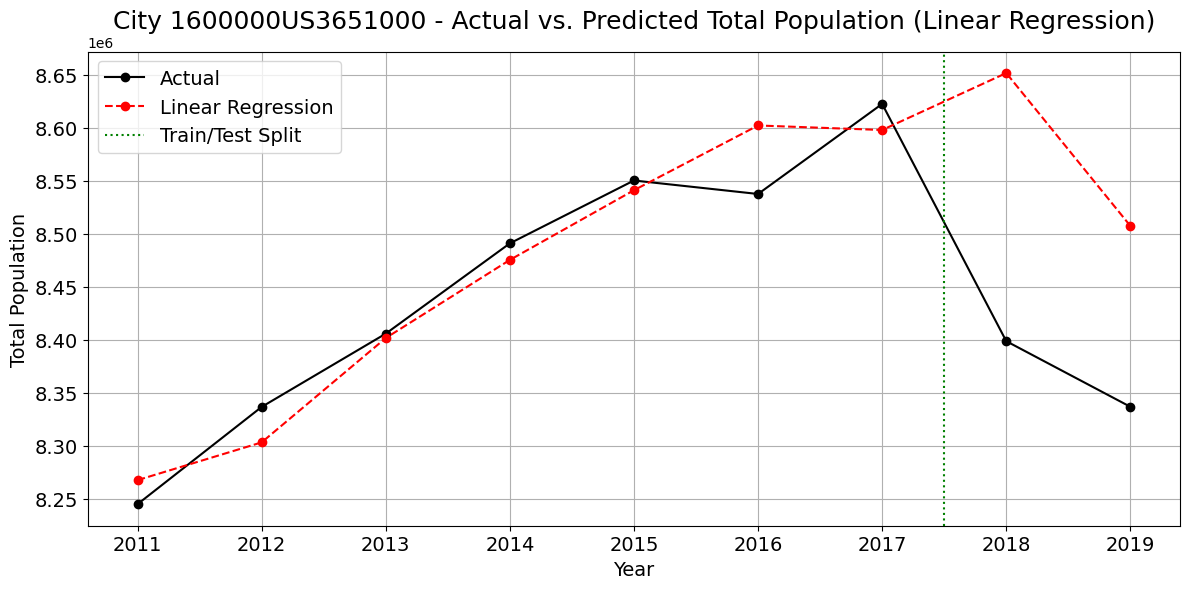

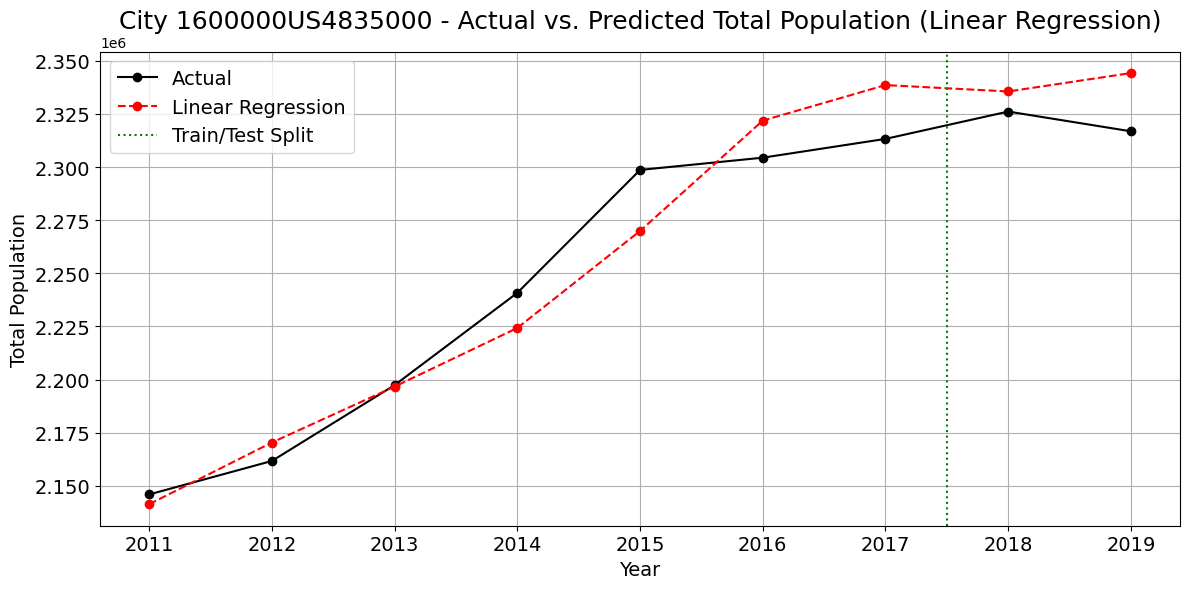

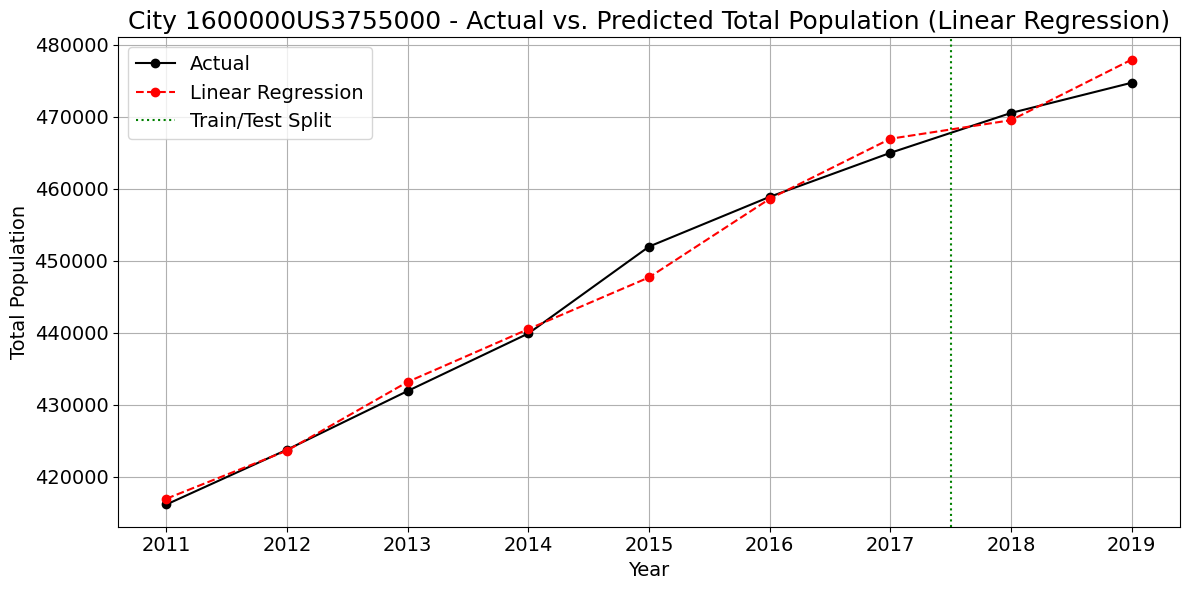

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load the CSV file
df = pd.read_csv('/Users/avakrocheski-meyer/Downloads/TASK: 1119_start_to_finish/6_feature_generation/all_lagged.csv')

# Define the Linear Regression model
lr_model = LinearRegression()

# Split the data into train and test sets based on the Year column
train_df = df[df['Year'].between(2010, 2016)].copy()
test_df = df[df['Year'].between(2017, 2018)].copy()

# Separate features and target variable for training and testing
X_train = train_df.drop(columns=['target_TOT_POPULATION'])
y_train = train_df['target_TOT_POPULATION']

X_test = test_df.drop(columns=['target_TOT_POPULATION'])
y_test = test_df['target_TOT_POPULATION']

# Remove 'GEO_ID' and 'Year' from the feature sets
X_train_features = X_train.drop(columns=['GEO_ID', 'Year'])
X_test_features = X_test.drop(columns=['GEO_ID', 'Year'])

# Train the Linear Regression model
lr_model.fit(X_train_features, y_train)

# Generate predictions on the entire dataset (training and test sets combined)
train_df['Actual'] = np.exp(y_train.values)
train_df['Pred_LR'] = np.exp(lr_model.predict(X_train_features))
test_df['Actual'] = np.exp(y_test.values)
test_df['Pred_LR'] = np.exp(lr_model.predict(X_test_features))

# Concatenate training and test data for complete visualization
full_df = pd.concat([train_df, test_df])

# Identify residuals for all cities
full_df['Residual'] = full_df['Actual'] - full_df['Pred_LR']

# Identify the two best-performing cities (smallest absolute residuals)
best_cities = full_df.groupby('GEO_ID')['Residual'].apply(lambda x: np.mean(np.abs(x))).nsmallest(2).index

# Identify the two worst-performing cities (largest absolute residuals)
worst_cities = full_df.groupby('GEO_ID')['Residual'].apply(lambda x: np.mean(np.abs(x))).nlargest(2).index

# Identify the median-performing city (closest to the median absolute residual)
median_city = full_df.groupby('GEO_ID')['Residual'].apply(lambda x: np.mean(np.abs(x))).sub(
    full_df.groupby('GEO_ID')['Residual'].apply(lambda x: np.mean(np.abs(x))).median()).abs().idxmin()

# Plot time series for the selected cities
selected_cities = list(best_cities) + list(worst_cities) + [median_city]

for city in selected_cities:
    city_data = full_df[full_df['GEO_ID'] == city].sort_values(by='Year')
    
    plt.figure(figsize=(12, 6))
    plt.plot(city_data['Year'] + 1, city_data['Actual'], color='black', label='Actual', marker='o')
    plt.plot(city_data['Year'] + 1, city_data['Pred_LR'], color='red', linestyle='--', marker='o', label='Linear Regression')
    
    # Add a vertical line at the end of 2016 to separate training and test sets
    plt.axvline(x=2017.5, color='green', linestyle=':', linewidth=1.5, label='Train/Test Split')

    plt.title(f'City {city} - Actual vs. Predicted Total Population (Linear Regression)', fontsize=18)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Total Population', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize = 14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


No Final Model in Cross-Validation:
Cross-validation does not produce a final model. Instead, it gives you an evaluation of model performance.
After cross-validation, you typically retrain a single model on the entire training set (not on folds) for real-world use.


# Residual Plots

In [97]:
import matplotlib.pyplot as plt
import numpy as np

def plot_residuals_log_scale(y_true, y_pred, model_name, dataset_type='Training'):
    """
    Plots residuals in log-transformed space for the given true and predicted values.

    Parameters:
    - y_true: Array of actual target values in log space.
    - y_pred: Array of predicted target values in log space.
    - model_name: Name of the model (str).
    - dataset_type: Type of dataset ('Training' or 'Test') for labeling.
    """
    # Calculate residuals in log space
    residuals = y_true - y_pred  # Residuals in log scale
    
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, edgecolor='k')
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Residual Line')
    
    # Labels and title
    plt.title(f'Residual Plot for {model_name} ({dataset_type} Data, Log Scale)', fontsize=18)
    plt.xlabel('Predicted Values (Log Scale)', fontsize=16)
    plt.ylabel('Residuals (Log Scale)', fontsize=16)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize = 12)
    plt.tight_layout()
    plt.show()


In [94]:

def plot_residuals(y_true, y_pred, model_name, dataset_type='Training'):
    """
    Plots residuals in log-transformed space for the given true and predicted values.

    Parameters:
    - y_true: Array of actual target values in log space.
    - y_pred: Array of predicted target values in log space.
    - model_name: Name of the model (str).
    - dataset_type: Type of dataset ('Training' or 'Test') for labeling.
    """
    # Calculate residuals in log space
    residuals = np.exp(y_true) - np.exp(y_pred)  # Residuals in log scale
    y_pred_log = np.exp(y_pred)
    
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_log, residuals, alpha=0.6, edgecolor='k')
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Residual Line')
    
    # Labels and title
    plt.title(f'Residual Plot for {model_name} ({dataset_type} Data)', fontsize=18)
    plt.xlabel('Predicted Values (Population, Number of People)', fontsize=16)
    plt.ylabel('Residuals (Number of People)', fontsize=16)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize = 12)
    plt.tight_layout()
    plt.show()

In [99]:
import matplotlib.pyplot as plt
import numpy as np

def plot_residuals_log_scale_test(y_true, y_pred, model_name):
    """
    Plots residuals in log-transformed space for the test data.

    Parameters:
    - y_true: Array of actual target values in log space (test data).
    - y_pred: Array of predicted target values in log space (test data).
    - model_name: Name of the model (str).
    """
    # Calculate residuals in log scale
    residuals = y_true - y_pred  # Residuals in log scale
    
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, edgecolor='k')
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Residual Line')
    
    # Labels and title
    plt.title(f'Residual Plot for {model_name} (Test Data, Log Scale)', fontsize=18)
    plt.xlabel('Predicted Values (Log Scale)', fontsize=16)
    plt.ylabel('Residuals (Log Scale)', fontsize=16)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize = 12)
    plt.tight_layout()
    plt.show()


def plot_residuals_test(y_true, y_pred, model_name):
    """
    Plots residuals in the original scale for the test data.

    Parameters:
    - y_true: Array of actual target values in log space (test data).
    - y_pred: Array of predicted target values in log space (test data).
    - model_name: Name of the model (str).
    """
    # Calculate residuals in original scale
    residuals = np.exp(y_true) - np.exp(y_pred)  # Residuals in original scale
    y_pred_log = np.exp(y_pred)
    
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_log, residuals, alpha=0.6, edgecolor='k')
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Residual Line')
    
    # Labels and title
    plt.title(f'Residual Plot for {model_name} (Test Data)', fontsize=18)
    plt.xlabel('Predicted Values (Population, Number of People)', fontsize=16)
    plt.ylabel('Residuals (Number of People)', fontsize=16)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize = 12)
    plt.tight_layout()
    plt.show()


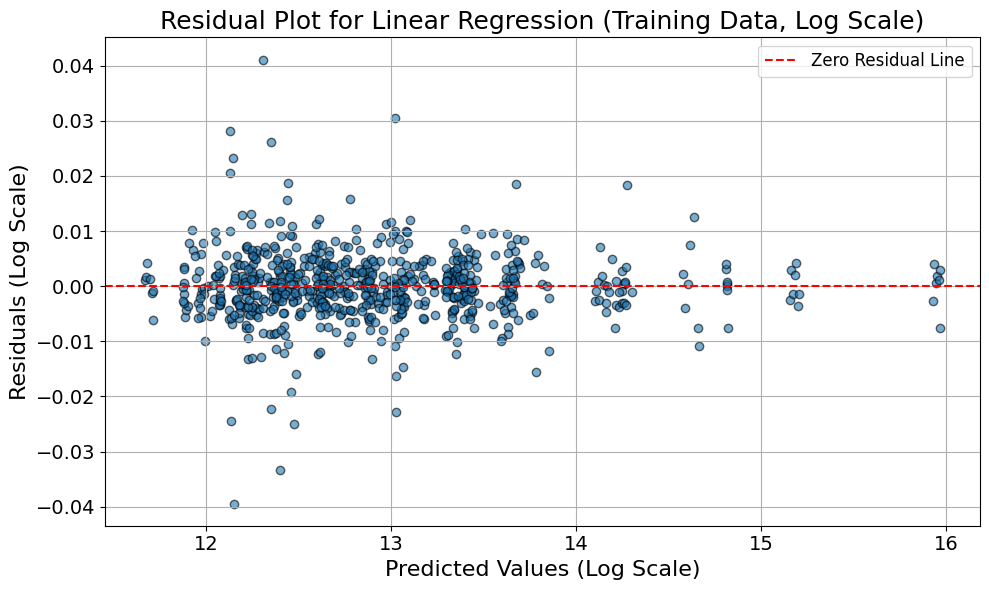

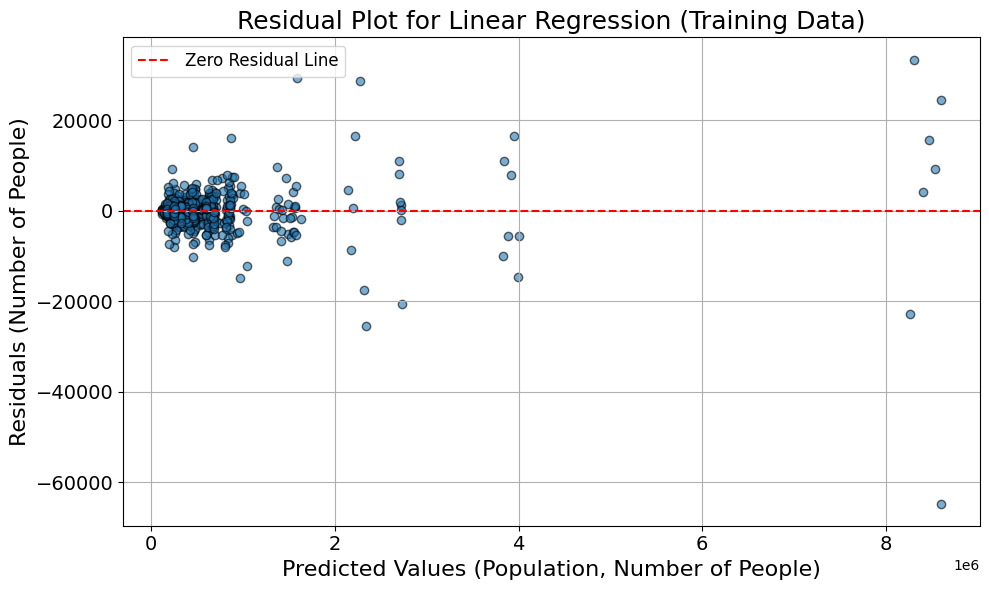

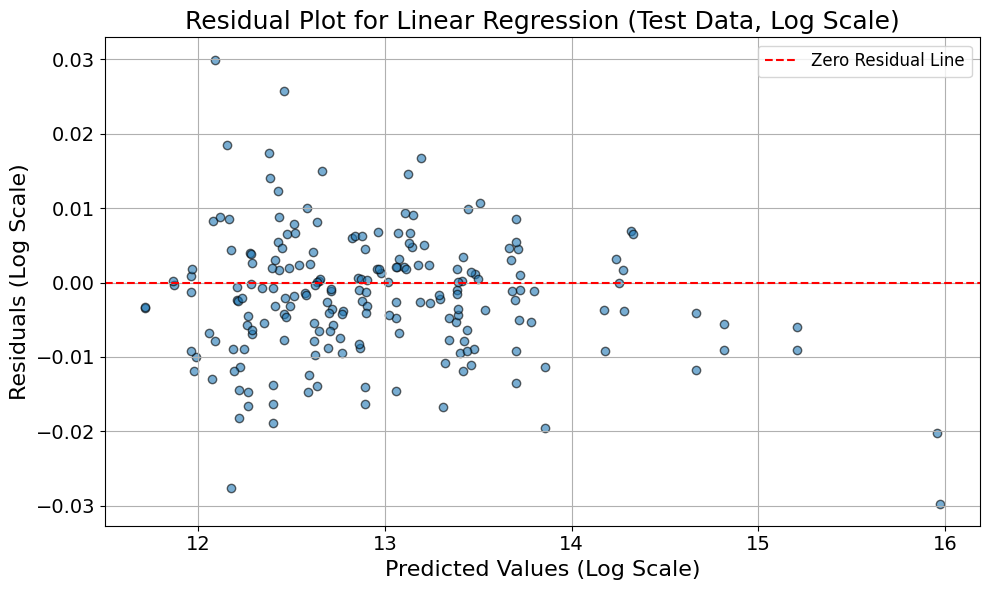

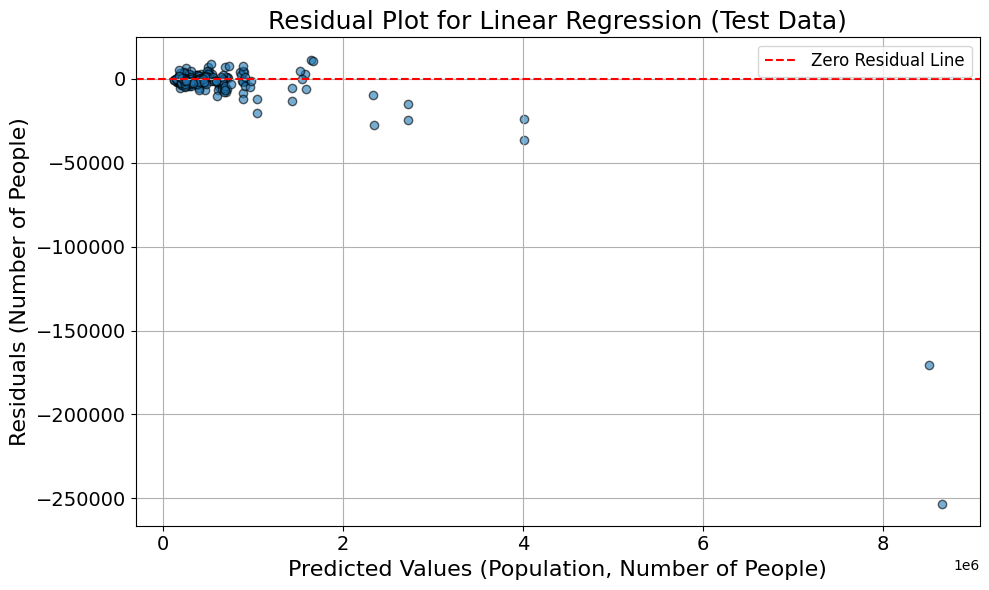

In [100]:
plot_residuals_log_scale(y_train, y_pred_lr_train, 'Linear Regression', 'Training')
# plot_residuals_log_scale(y_train, y_pred_rf_train, 'Random Forest', 'Training')
# plot_residuals_log_scale(y_train, y_pred_xgb_train, 'XG Boost', 'Training')

plot_residuals(y_train, y_pred_lr_train, 'Linear Regression', 'Training')
# plot_residuals(y_train, y_pred_rf_train, 'Random Forest', 'Training')
# plot_residuals(y_train, y_pred_xgb_train, 'XG Boost', 'Training')

# For log scale residual plot
plot_residuals_log_scale_test(y_test, y_pred_lr_test, model_name='Linear Regression')

# For residual plot in the original scale
plot_residuals_test(y_test, y_pred_lr_test, model_name='Linear Regression')
